# Analysis of dynamic network ABM
Standard networks, no SDA yet

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import random
import seaborn as sns
import networkx as nx
import cProfile
import pstats
import mesa
pd.set_option('display.max_colwidth', 10000)
import joblib
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
from mesa.batchrunner import BatchRunner

/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_60059/1271583795.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#from model import ConsumatModel
from model_no_homophily_dynamic import ConsumatModel

In [3]:
#Import KDE models

kde_modeks = {
    'ccrdprs': joblib.load('/Applications/UNI/Thesis/saved_data/kde_ccrdprs.pkl'),
    'gvsrdcc': joblib.load('/Applications/UNI/Thesis/saved_data/kde_gvsrdcc.pkl'),
    'hincfel': joblib.load('/Applications/UNI/Thesis/saved_data/kde_hincfel.pkl'),
    'impenv': joblib.load('/Applications/UNI/Thesis/saved_data/kde_impenv.pkl'),
    'impfree': joblib.load('/Applications/UNI/Thesis/saved_data/kde_impfree.pkl'),
    'imprich': joblib.load('/Applications/UNI/Thesis/saved_data/kde_imprich.pkl'),
    'inctxff': joblib.load('/Applications/UNI/Thesis/saved_data/kde_inctxff.pkl'),
    'inprdsc': joblib.load('/Applications/UNI/Thesis/saved_data/kde_inprdsc.pkl'),
    'ipfrule': joblib.load('/Applications/UNI/Thesis/saved_data/kde_ipfrule.pkl'),
    'iplylfr': joblib.load('/Applications/UNI/Thesis/saved_data/kde_iplylfr.pkl'),
    'lkredcc': joblib.load('/Applications/UNI/Thesis/saved_data/kde_lkredcc.pkl'),
    'sclmeet': joblib.load('/Applications/UNI/Thesis/saved_data/kde_sclmeet.pkl'),
    'wrclmch': joblib.load('/Applications/UNI/Thesis/saved_data/kde_wrclmch.pkl'),
    'wrkctra': joblib.load('/Applications/UNI/Thesis/saved_data/kde_wrkctra.pkl')
}

In [18]:
base_config = {
    'TP_percentage': 0.7,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'kde_models_dir': '/Applications/UNI/Thesis/saved_data/',
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'seed': 42  # Seed for reproducibility
}

# Configuration for Watts-Strogatz network
watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1000,
        'k': 8,
        'p': 0.3
    }
})


# Configuration for Barabasi-Albert network
barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1000,
        'm': 8
    }
})

# Configuration for Random Regular network
random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1000,
        'd': 8
    }
})

# Configuration for Holme-Kim network
holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1000,
        'm': 8,
        'p': 0.3
    }
})


## Network topology

### Watts-Strogatz Network
- **Type:** Small-world network
- **Known For:** High clustering coefficient and short average path lengths, which mimic many real-world social networks.
- **Formation:** Starts with a ring of `n` nodes each connected to `k` nearest neighbors. Rewires each edge with probability `p` to a randomly chosen node.
- **Key Parameters:**
  - `n`: Number of nodes
  - `k`: Number of nearest neighbors in the initial ring topology
  - `p`: Probability of rewiring each edge

### Barabasi-Albert Network
- **Type:** Scale-free network
- **Known For:** Its degree distribution follows a power law, which is typical for many large networks such as the internet, citation networks, and some social networks.
- **Formation:** Begins with a small number of nodes and adds new nodes one at a time. Each new node is connected to `k` existing nodes with a probability that depends on the number of links that the existing nodes already have.
- **Key Parameters:**
  - `n`: Total number of nodes
  - `m`: Number of edges to attach from a new node to existing nodes

### Random Regular Network
- **Type:** Regular graph
- **Known For:** Every node has the same number of connections. This uniformity can represent idealized conditions in network modeling.
- **Formation:** Constructed by connecting each node with `d` neighbors chosen at random, ensuring each has the same degree, while avoiding self-loops and duplicate edges.
- **Key Parameters:**
  - `n`: Total number of nodes
  - `d`: Degree of each node

### Holme-Kim Network
- **Type:** Small-world network with scale-free properties
- **Known For:** Combines high clustering and short path lengths (like Watts-Strogatz) with a degree distribution that follows a power law (like Barabasi-Albert).
- **Formation:** Starts like the Barabasi-Albert model by adding one node at a time, connecting to `m` existing nodes based on their degree. After each edge creation, with probability `p` adds an additional edge forming a triangle.
- **Key Parameters:**
  - `n`: Total number of nodes
  - `m`: Number of edges each new node will attempt to make
  - `p`: Triad formation probability



In [19]:

def run_simulation(model, num_steps):
    # List to store True Price Adoption Rates
    adoption_rates = []

    # Run the model for a specified number of steps with tqdm for progress tracking
    for _ in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        # Calculate and append the current adoption rate to the list
        current_adoption_rate = model.calculate_true_price_adoption_rate()
        adoption_rates.append(current_adoption_rate)

    # Retrieve collected data from the model's DataCollector
    model_data = model.datacollector.get_model_vars_dataframe()
    agent_data = model.datacollector.get_agent_vars_dataframe()
    # Append the adoption rates to the DataFrame
    model_data['Adoption Rates'] = adoption_rates  # Ensure this matches how you collect data in DataCollector

    return model_data, agent_data

def run_all_simulations(configurations, num_steps):
    results = {}
    for config_name, config in configurations.items():
        print(f"Running simulation for {config_name} network...")
        model = ConsumatModel(config)  # Pass the configuration as a single argument
        model_data, agent_data = run_simulation(model, num_steps)
        results[config_name] = (model_data, agent_data)

        # Plotting True Price Adoption Rates
        plt.figure(figsize=(10, 6))
        plt.plot(model_data['Adoption Rates'], marker='o', color='b')
        plt.title(f'True Price Adoption Rate Over Iterations for {config_name}')
        plt.xlabel('Iteration')
        plt.ylabel('True Price Adoption Rate (%)')
        plt.grid(True)
        plt.show()

        # Plotting Network Metrics
        plt.figure(figsize=(10, 5))
        if 'Average Degree' in model_data.columns:
            plt.plot(model_data['Average Degree'], label='Average Degree')
        if 'Variance of Degree' in model_data.columns:
            plt.plot(model_data['Variance of Degree'], label='Variance of Degree')
        if 'Average Clustering' in model_data.columns:
            plt.plot(model_data['Average Clustering'], label='Average Clustering')
        if 'Average Path Length' in model_data.columns:
            plt.plot(model_data['Average Path Length'], label='Average Path Length', linestyle='--')
        plt.xlabel('Step')
        plt.ylabel('Metric Value')
        plt.title(f'Network Metrics Over Time for {config_name}')
        plt.legend()
        plt.show()

    return results

# Define the configurations for each network type
network_configurations = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}




Running simulation for Watts-Strogatz network...


Simulation Progress: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s]


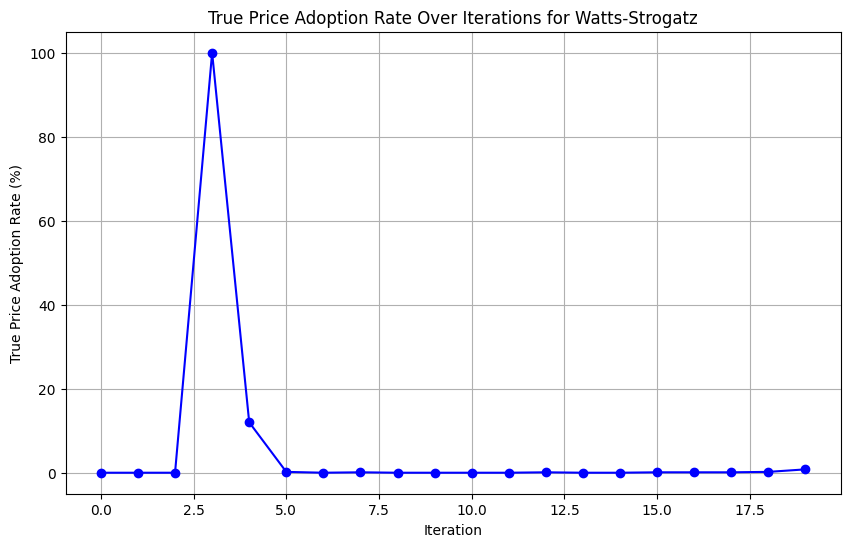

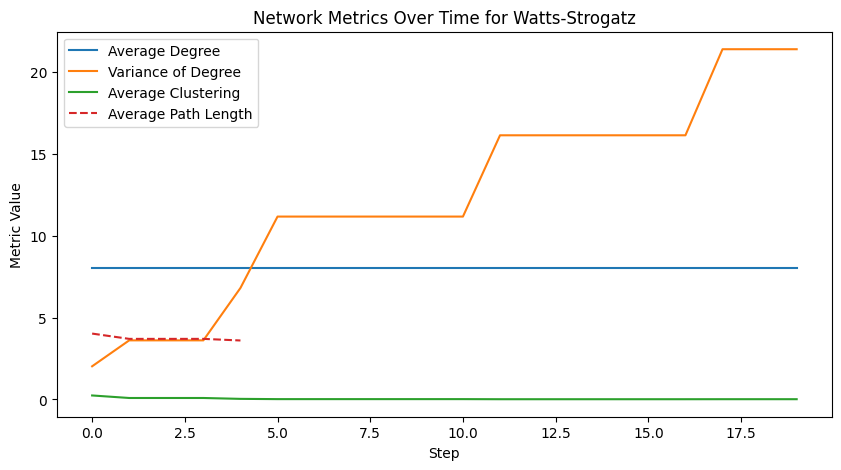

Running simulation for Barabasi-Albert network...


Simulation Progress: 100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


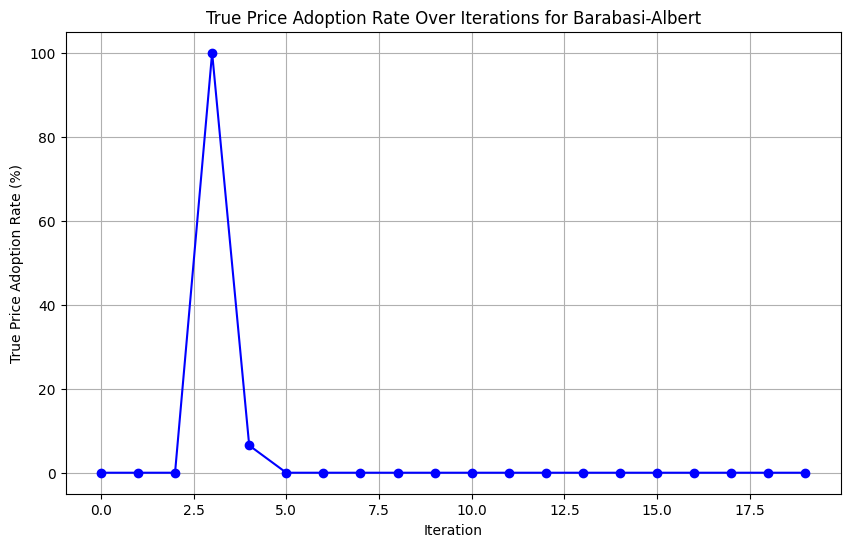

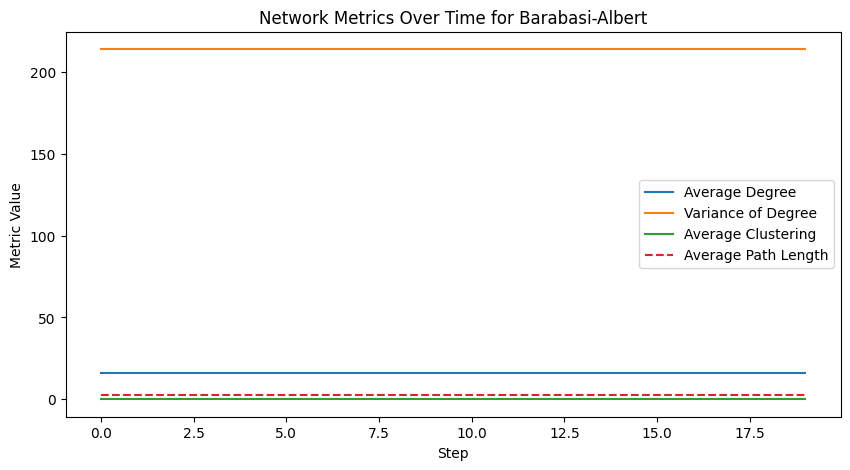

Running simulation for Random Regular network...


Simulation Progress: 100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


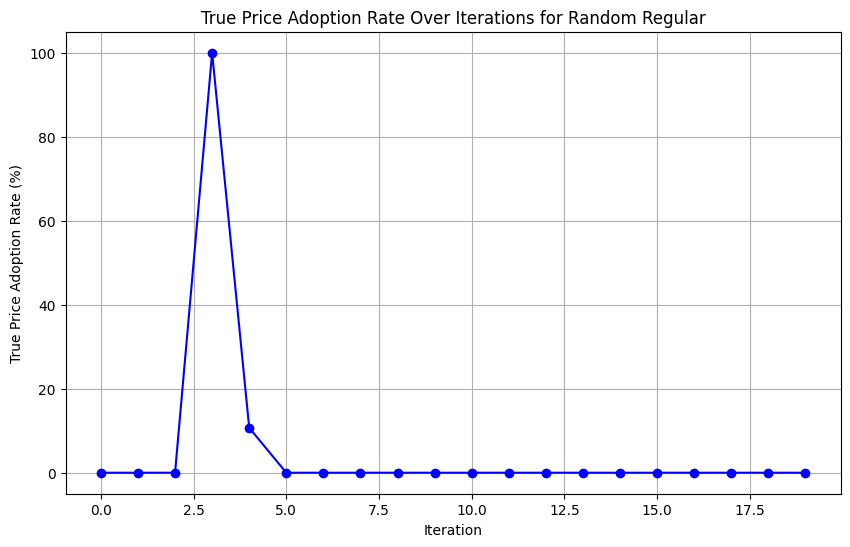

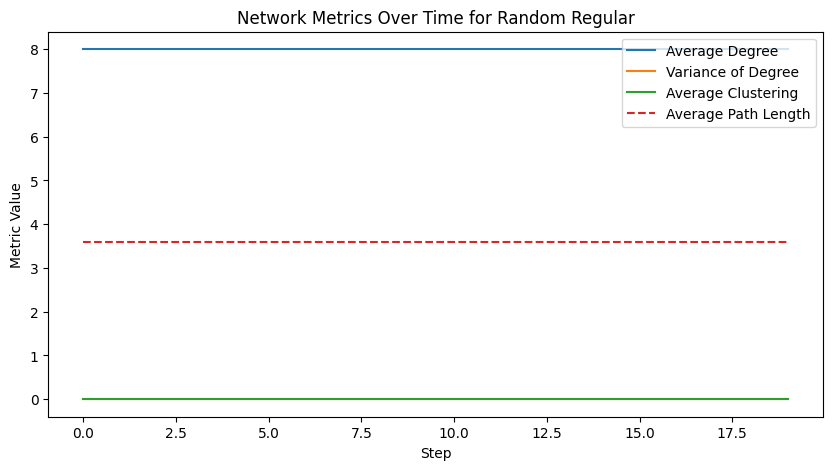

Running simulation for Holme-Kim network...


Simulation Progress: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


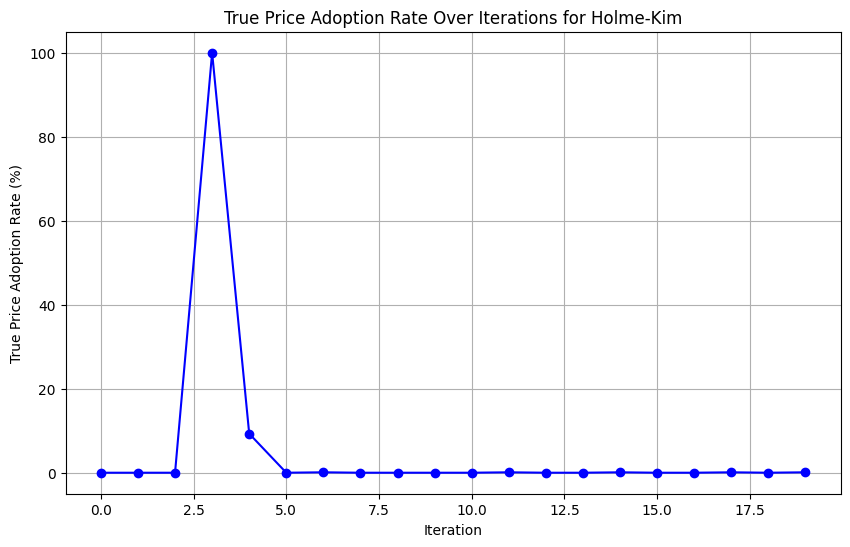

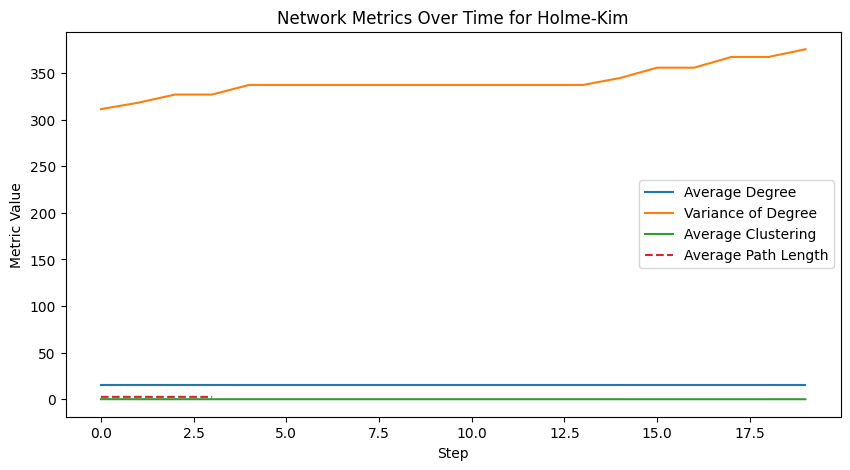

Results for Watts-Strogatz network:
    True_Price_Adoption_Rate  Average_Satisfaction  Average_Choice_Changes  \
0                       0.0              0.310991                   0.000   
1                       0.0              0.310991                   0.000   
2                       0.0              0.310991                   0.000   
3                     100.0              0.523246                   0.880   
4                      12.0              0.509749                   1.002   

   Average_Decision_Mode_Changes  Average Degree  Variance of Degree  \
0                          1.000             8.0               2.024   
1                          1.000             8.0               3.606   
2                          1.000             8.0               3.606   
3                          1.880             8.0               3.606   
4                          2.688             8.0               6.802   

   Average Clustering  Average Path Length  Adoption Rates  
0     

In [20]:
# Execute the simulations for all network configurations
results = run_all_simulations(network_configurations, 20)

# Print or process the results
for network_type, (model_data, agent_data) in results.items():
    print(f"Results for {network_type} network:\n", model_data.head())
    # Process decision modes count
    decision_modes_count = agent_data.groupby('Step').sum()[['Repeat', 'Imitate', 'Deliberate', 'Social_Compare']]
    print(f"Decision modes count for {network_type} network:\n", decision_modes_count)


### Multiple runs of the same model:

Running simulations for Watts-Strogatz network...


Simulation Progress: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


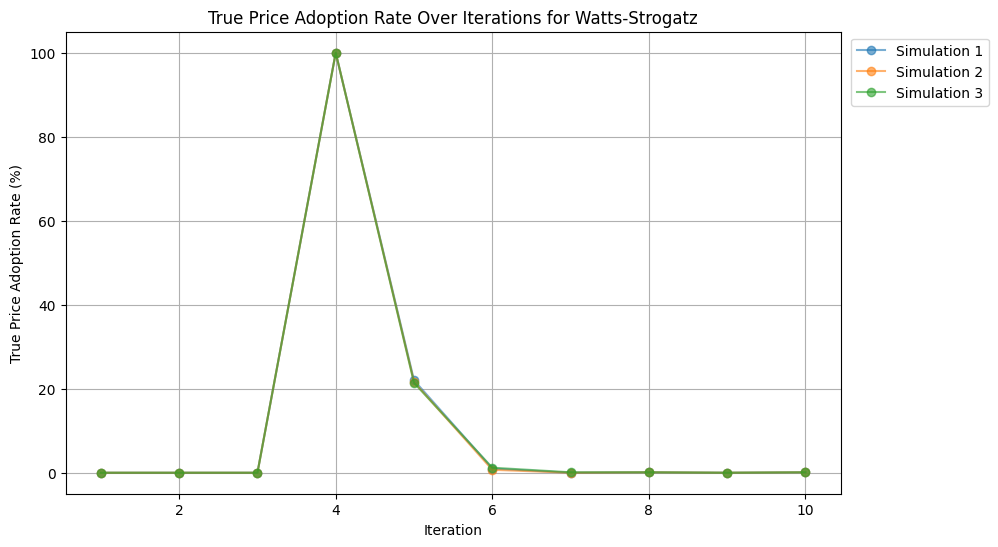

Running simulations for Barabasi-Albert network...


Simulation Progress: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


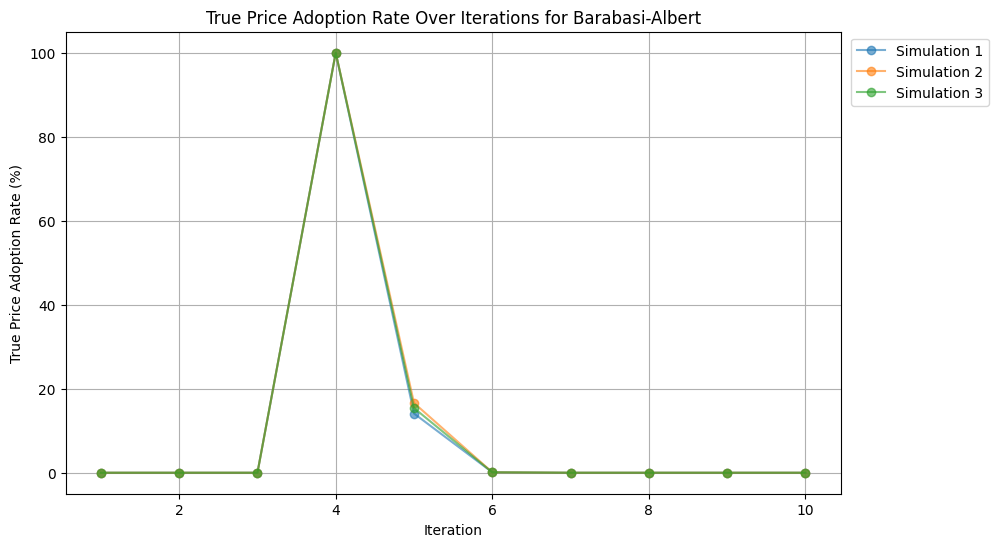

Running simulations for Random Regular network...


Simulation Progress: 100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


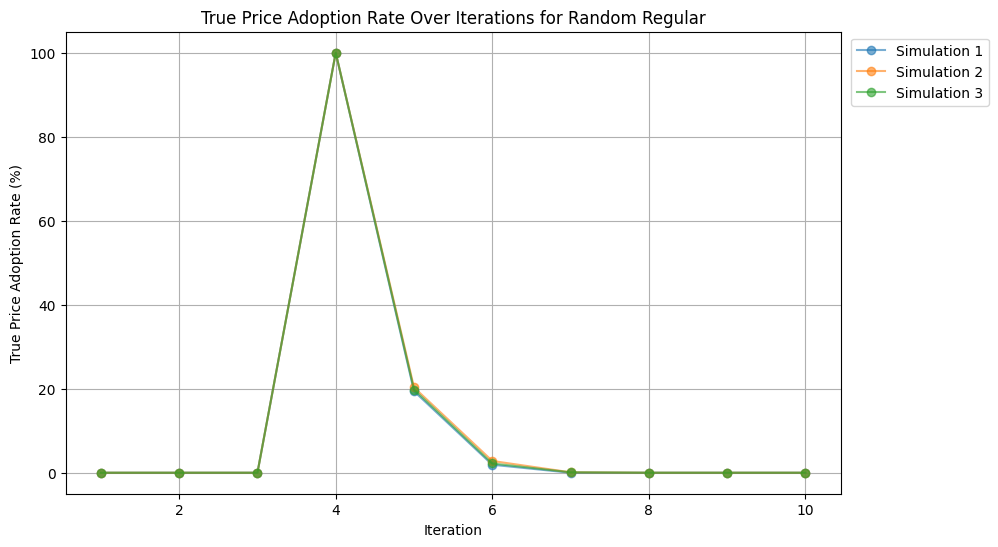

Running simulations for Holme-Kim network...


Simulation Progress: 100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


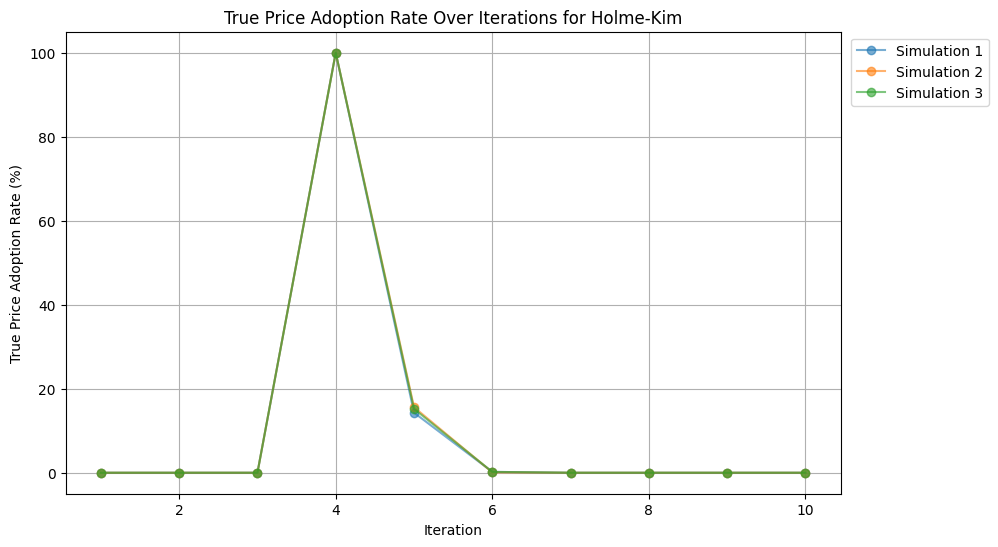

In [7]:
# Number of simulations
num_simulations = 3

# Number of steps per simulation
num_steps = 10

# Loop over each network configuration
for config_name, config in network_configurations.items():
    print(f"Running simulations for {config_name} network...")
    
    # Initialize a figure for plotting for this network type
    plt.figure(figsize=(10, 6))

    # Loop over the number of simulations
    for simulation in range(num_simulations):
        # Initialize your model with the current configuration
        model = ConsumatModel(config)
        
        # Run the model for a specified number of steps and collect data
        simulation_data = run_simulation(model, num_steps)

        # Plotting the results for the current simulation
        plt.plot(range(1, num_steps + 1), simulation_data['Adoption Rates'], marker='o', alpha=0.6, label=f'Simulation {simulation+1}')

    # Finalizing the plot for this network type
    plt.title(f'True Price Adoption Rate Over Iterations for {config_name}')
    plt.xlabel('Iteration')
    plt.ylabel('True Price Adoption Rate (%)')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.grid(True)
    plt.show()



### Vary network parameters

Simulation Progress: 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


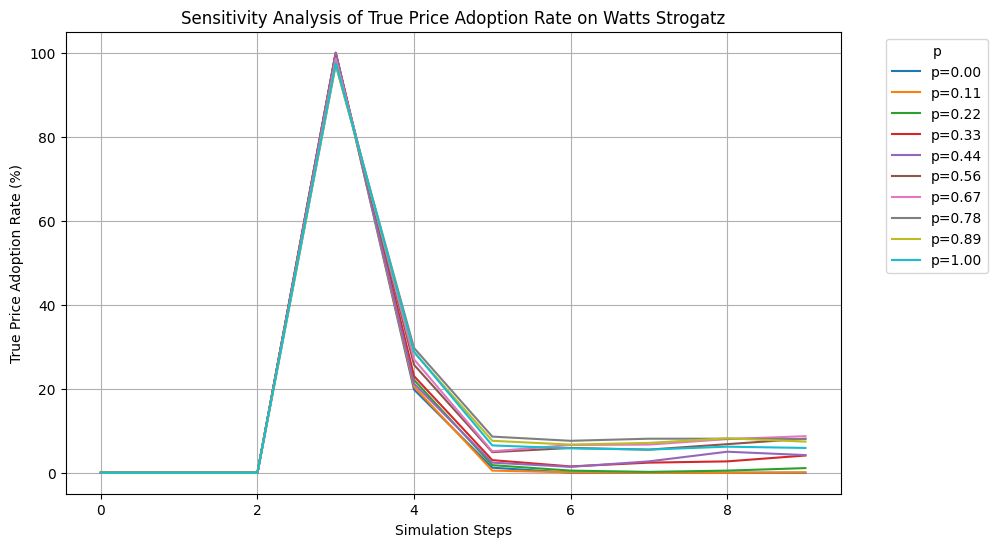

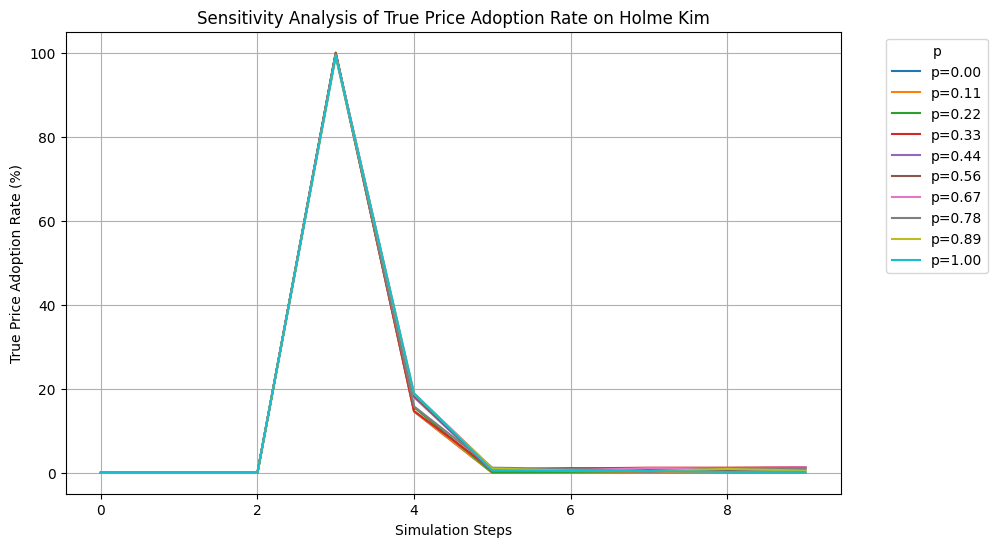

In [8]:

def run_simulation_with_varying_network_params(base_config, parameter_name, parameter_values, num_steps):
    all_results = {}
    for value in parameter_values:
        # Update the network parameter
        config = base_config.copy()
        config['network_params'][parameter_name] = value
        model = ConsumatModel(config)
        result = run_simulation(model, num_steps)
        all_results[value] = result['Adoption Rates']
    return all_results

# Example for varying 'p' in a Watts-Strogatz network
parameter_name = 'p'
parameter_values = np.linspace(0, 1, 10)
num_steps = 10
watts_strogatz_results = run_simulation_with_varying_network_params(
    watts_strogatz_config,
    parameter_name,
    parameter_values,
    num_steps
)

holme_kim_results = run_simulation_with_varying_network_params(
    holme_kim_config,
    parameter_name,
    parameter_values,
    num_steps
)


# Plot the results
plt.figure(figsize=(10, 6))
for value, adoption_rates in watts_strogatz_results.items():
    plt.plot(range(num_steps), adoption_rates, label=f'{parameter_name}={value:.2f}')
plt.title('Sensitivity Analysis of True Price Adoption Rate on Watts Strogatz')
plt.xlabel('Simulation Steps')
plt.ylabel('True Price Adoption Rate (%)')
plt.legend(title=parameter_name, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Plot the results
plt.figure(figsize=(10, 6))
for value, adoption_rates in holme_kim_results.items():
    plt.plot(range(num_steps), adoption_rates, label=f'{parameter_name}={value:.2f}')
plt.title('Sensitivity Analysis of True Price Adoption Rate on Holme Kim')
plt.xlabel('Simulation Steps')
plt.ylabel('True Price Adoption Rate (%)')
plt.legend(title=parameter_name, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()



### Vary True Price percentage

Simulation Progress: 100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


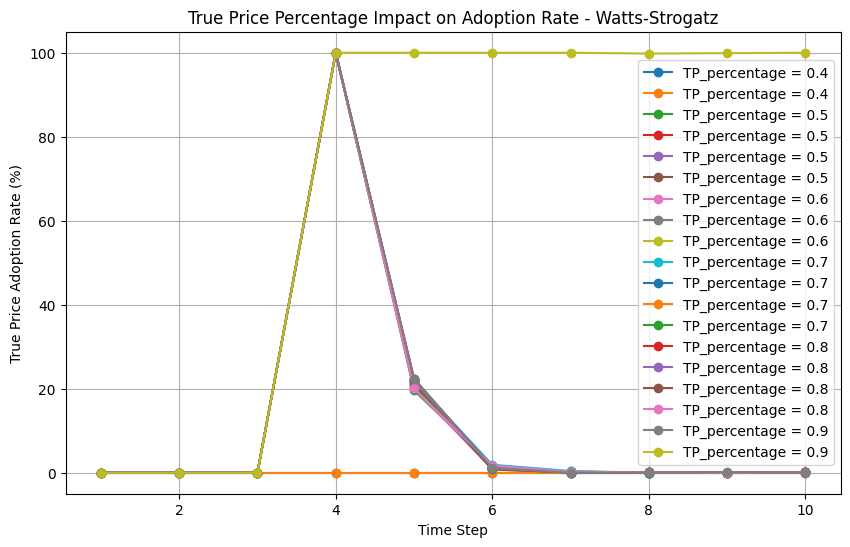

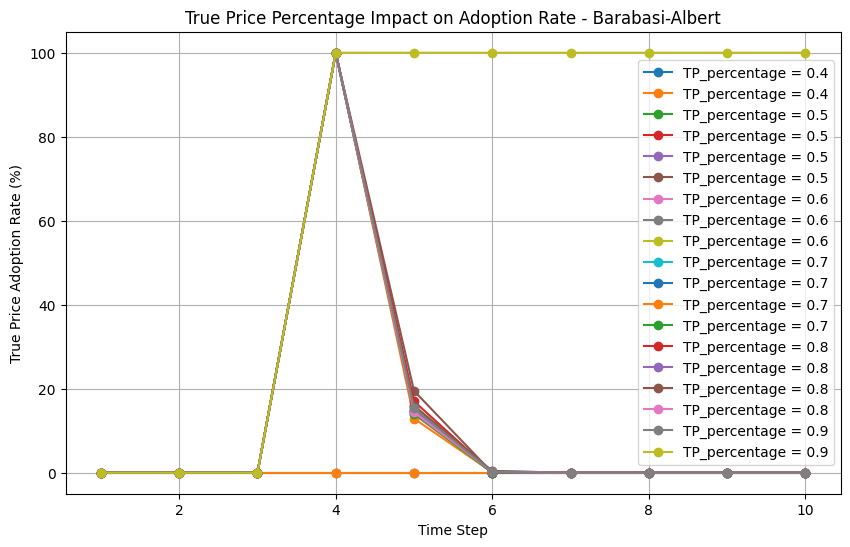

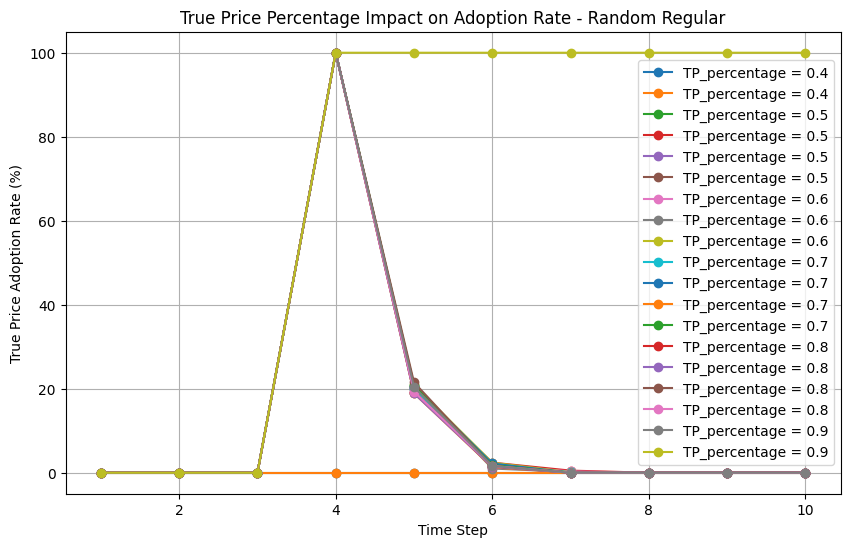

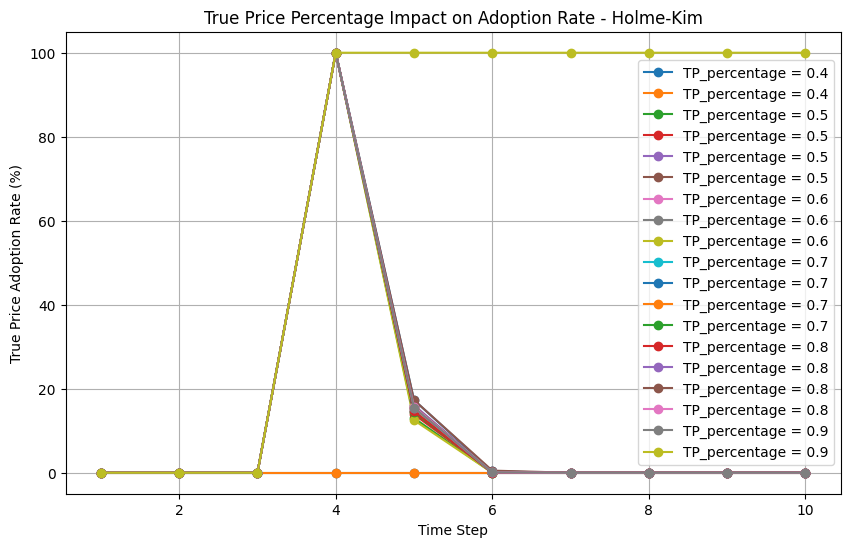

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming ConsumatModel and run_simulation are defined elsewhere

# Base configuration
base_config = {
    'TP_percentage': 0.7,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'kde_models_dir': '/Applications/UNI/Thesis/saved_data/',
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'seed': 42  # Seed for reproducibility
}

# Network configurations
network_configs = {
    'Watts-Strogatz': {
        'network_type': 'watts_strogatz',
        'network_params': {
            'n': 1000,
            'k': 4,
            'p': 0.2
        }
    },
    'Barabasi-Albert': {
        'network_type': 'barabasi_albert',
        'network_params': {
            'n': 1000,
            'm': 4
        }
    },
    'Random Regular': {
        'network_type': 'random_regular',
        'network_params': {
            'n': 1000,
            'd': 4
        }
    },
    'Holme-Kim': {
        'network_type': 'holme_kim',
        'network_params': {
            'n': 1000,
            'm': 4,
            'p': 0.1
        }
    }
}

# Define a range of values for TP_percentage
tp_percentages = np.linspace(0.4, 0.9, 19)  # From 10% to 90%, with increments of 10%

# Hold the number of steps constant for each simulation
num_steps = 10

# Function to run simulations for each TP_percentage
def run_simulation_for_tp_percentage(config, tp_percentages, num_steps):
    adoption_rates_by_tp_percentage = []

    for tp_percentage in tp_percentages:
        # Update the config with the current TP_percentage
        config['TP_percentage'] = tp_percentage
        
        # Run the simulation
        model = ConsumatModel(config)
        model_data = run_simulation(model, num_steps)
        
        # Extract the adoption rates from the DataFrame
        adoption_rates = model_data['Adoption Rates'].values
        
        # Store the adoption rates for this TP_percentage
        adoption_rates_by_tp_percentage.append(adoption_rates)
    
    return adoption_rates_by_tp_percentage

# Run simulations and collect results for all networks
all_network_results = {}
for network_name, network_config in network_configs.items():
    config = base_config.copy()
    config.update(network_config)
    adoption_rates_by_tp_percentage = run_simulation_for_tp_percentage(config, tp_percentages, num_steps)
    all_network_results[network_name] = adoption_rates_by_tp_percentage

# Plot the results for each network
for network_name, adoption_rates_by_tp_percentage in all_network_results.items():
    plt.figure(figsize=(10, 6))
    for i, tp_percentage in enumerate(tp_percentages):
        plt.plot(range(1, num_steps + 1), adoption_rates_by_tp_percentage[i], label=f'TP_percentage = {tp_percentage:.1f}', marker='o')
    plt.title(f'True Price Percentage Impact on Adoption Rate - {network_name}')
    plt.xlabel('Time Step')
    plt.ylabel('True Price Adoption Rate (%)')
    plt.legend()
    plt.grid(True)
    plt.show()


### All result metrics

Network: watts_strogatz
Average degree: 4.0
Rewiring probability: 0.2
Clustering coefficient: 0.28151428571428544
Average path length: 7.011283283283284
Degree distribution: (array([  0,   0,  28, 206, 540, 194,  32]), array([0, 1, 2, 3, 4, 5, 6, 7]))
Agent 0 has 4 neighbors
Agent 1 has 3 neighbors
Agent 2 has 3 neighbors
Agent 3 has 2 neighbors
Agent 4 has 5 neighbors


Simulation Progress: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


Network: barabasi_albert
Average degree: 7.968
Rewiring probability: N/A
Clustering coefficient: 0.03336718002479007
Average path length: 3.1895575575575577
Degree distribution: (array([  0,   0,   0,   0, 329, 190, 119,  84,  44,  41,  32,  22,  21,
        16,  12,   9,  10,   7,  10,   6,   4,   4,   3,   6,   1,   2,
         0,   1,   1,   1,   0,   2,   1,   2,   1,   2,   2,   1,   2,
         0,   1,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
         0,   1,   0,   1,   0,   0,   1,   0,   1,   0,   1,   0,   0,
         0,   1,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
         0,   0,   0,   0,   1,   0,   0,   0,   0,   1,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   1]), array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22, 

Simulation Progress: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Network: random_regular
Average degree: 4.0
Rewiring probability: N/A
Clustering coefficient: 0.0024999999999999996
Average path length: 5.645251251251251
Degree distribution: (array([   0,    0,    0, 1000]), array([0, 1, 2, 3, 4]))
Agent 0 has 4 neighbors
Agent 1 has 4 neighbors
Agent 2 has 4 neighbors
Agent 3 has 4 neighbors
Agent 4 has 4 neighbors


Simulation Progress: 100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


Network: holme_kim
Average degree: 7.96
Rewiring probability: 0.1
Clustering coefficient: 0.07129409977493154
Average path length: 3.1996856856856857
Degree distribution: (array([  0,   0,   0,   1, 331, 197, 120,  77,  49,  41,  26,  17,  22,
        15,  12,   9,   8,   8,  11,   7,   8,   3,   2,   1,   2,   0,
         1,   2,   1,   1,   3,   2,   0,   3,   0,   0,   2,   2,   0,
         2,   0,   2,   1,   0,   0,   0,   0,   0,   0,   1,   0,   0,
         0,   1,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   1,
         1,   0,   2,   0,   0,   0,   0,   0,   0,   0,   1,   0,   1,
         1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   1]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65

Simulation Progress: 100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


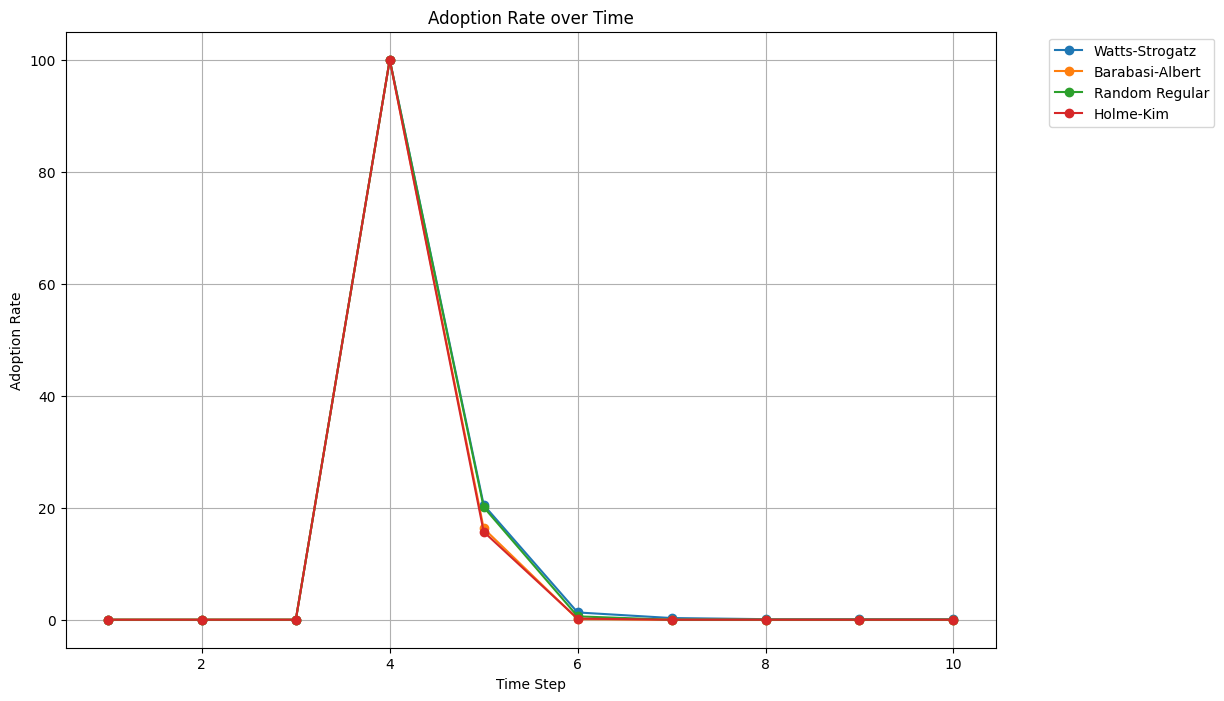

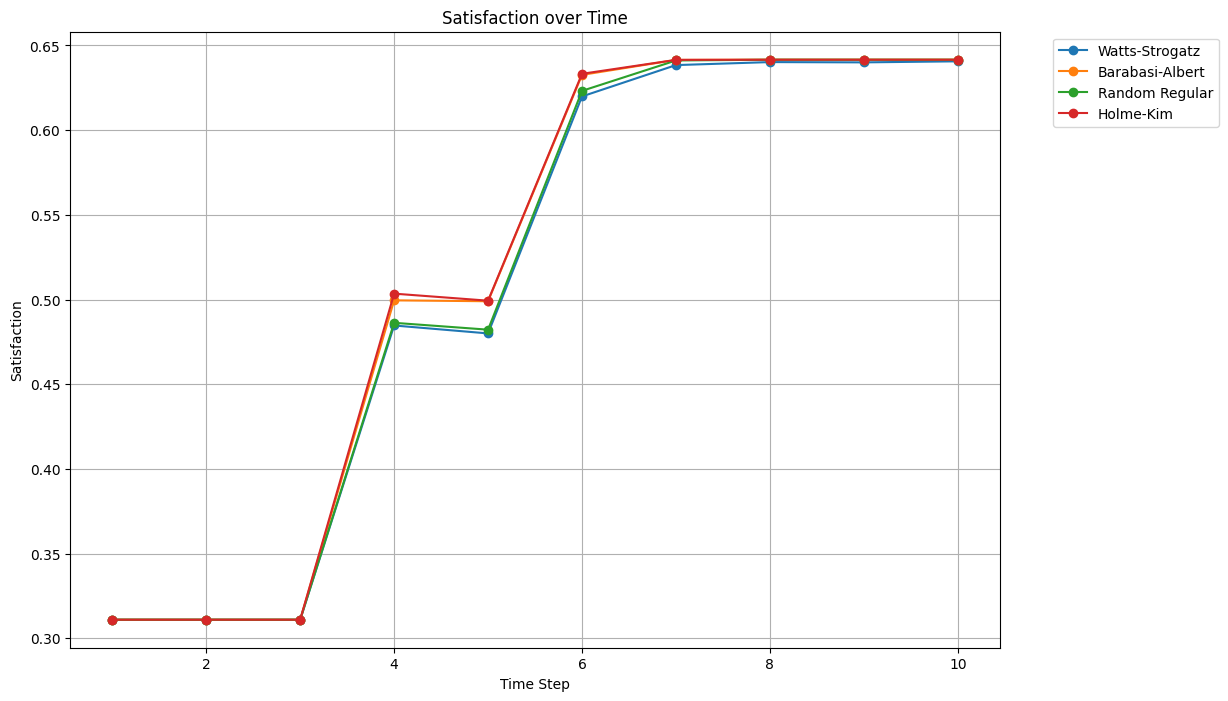

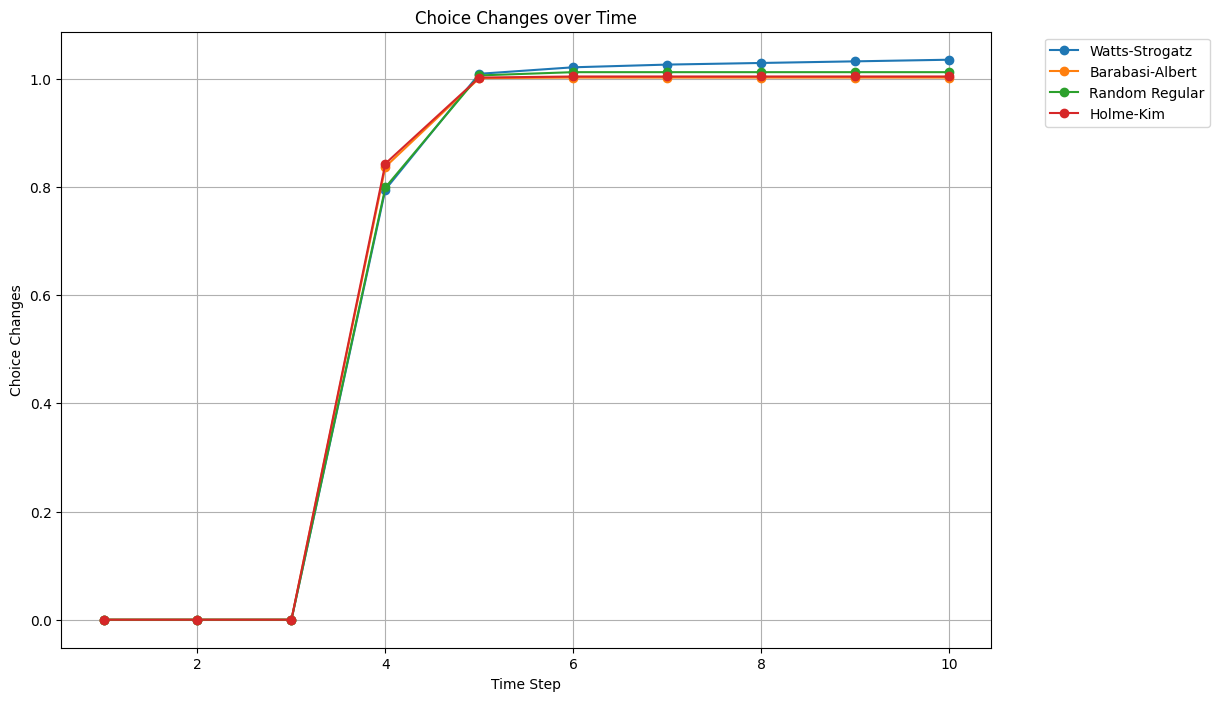

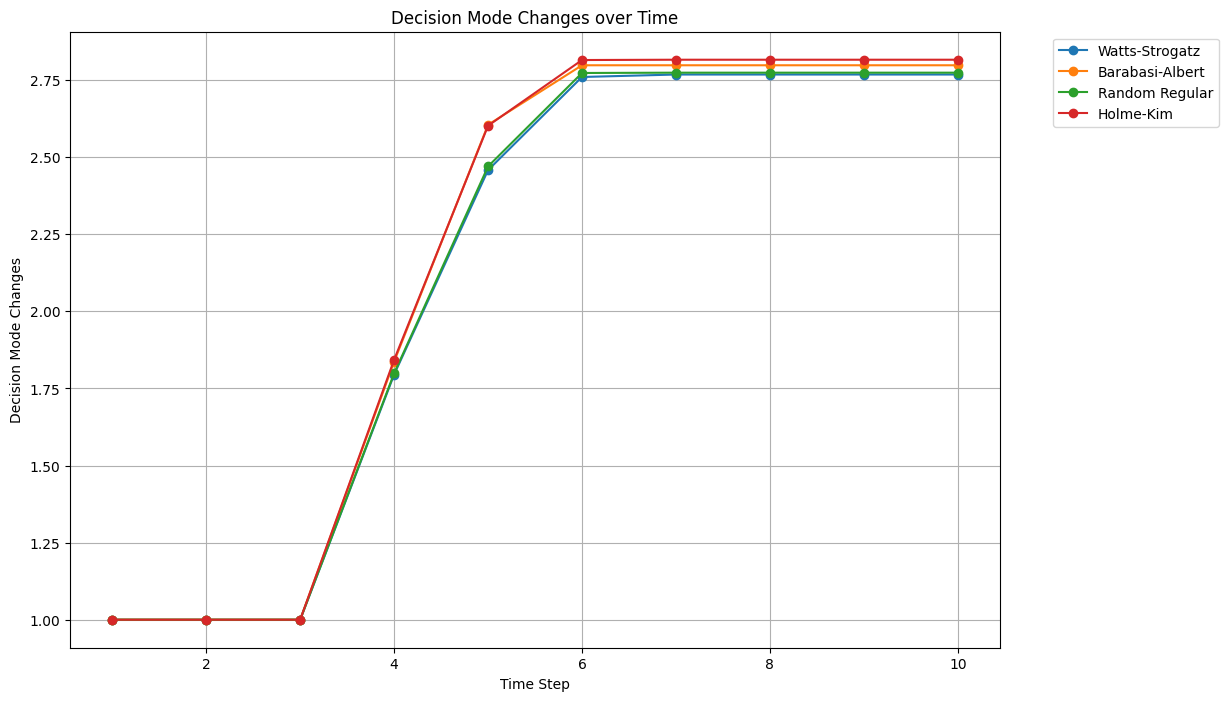

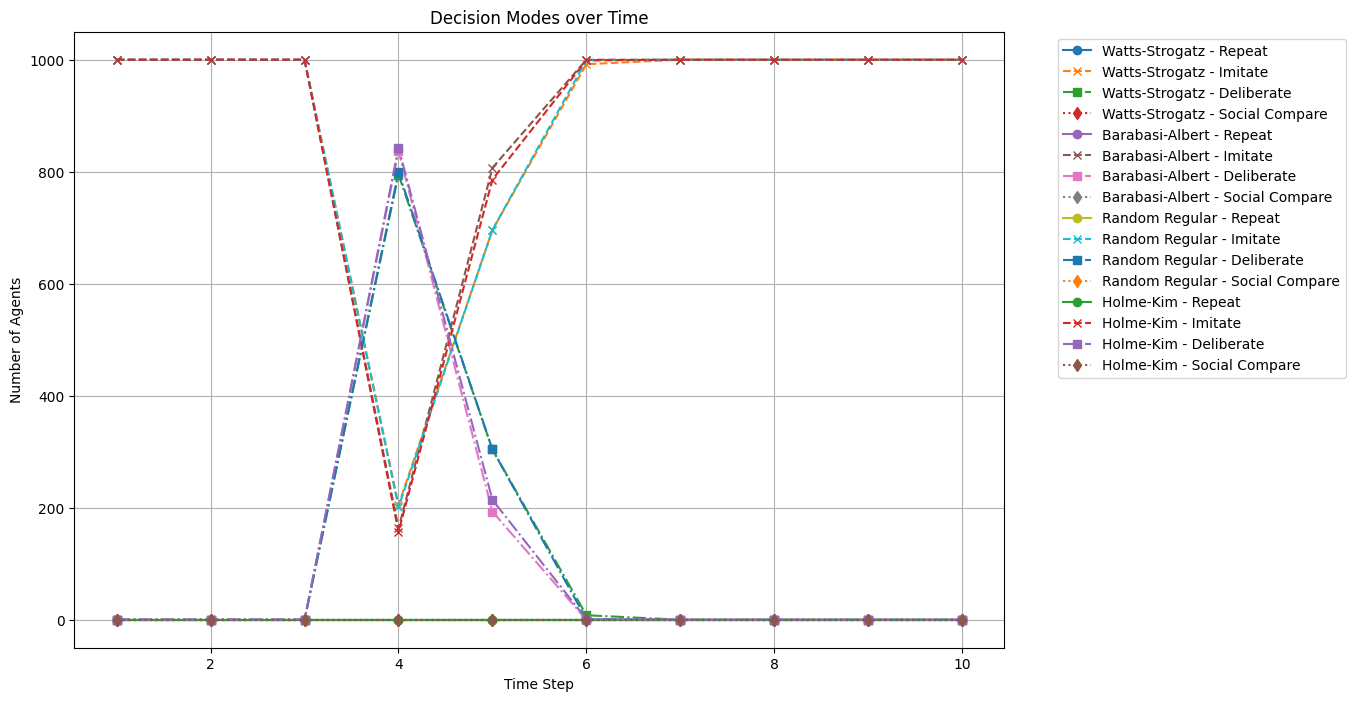

In [11]:

# Base configuration
base_config = {
    'TP_percentage': 0.7,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'kde_models_dir': '/Applications/UNI/Thesis/saved_data/',
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'seed': 42  # Seed for reproducibility
}

# Network configurations with a constant 'degree' parameter
network_configs = {
    'Watts-Strogatz': {
        'network_type': 'watts_strogatz',
        'network_params': {
            'n': 1000,
            'k': 4,  
            'p': 0.2
        }
    },
    'Barabasi-Albert': {
        'network_type': 'barabasi_albert',
        'network_params': {
            'n': 1000,
            'm': 4  
        }
    },
    'Random Regular': {
        'network_type': 'random_regular',
        'network_params': {
            'n': 1000,
            'd': 4  
        }
    },
    'Holme-Kim': {
        'network_type': 'holme_kim',
        'network_params': {
            'n': 1000,
            'm': 4,  
            'p': 0.1
        }
    }
}

# Hold the number of steps constant for each simulation
num_steps = 10

# Function to run simulations for the network configurations
def run_simulation_for_networks(config, num_steps):
    results = { 'Adoption Rate': [], 'Satisfaction': [], 'Choice Changes': [], 'Decision Mode Changes': [], 'Decision Modes': [] }

    # Run the simulation
    model = ConsumatModel(config)

    # Debug: Print network properties
    G = model.get_network()
    print(f"Network: {config['network_type']}")
    print(f"Average degree: {np.mean([d for n, d in G.degree()])}")
    print(f"Rewiring probability: {config['network_params'].get('p', 'N/A')}")
    print(f"Clustering coefficient: {nx.average_clustering(G)}")
    if nx.is_connected(G):
        print(f"Average path length: {nx.average_shortest_path_length(G)}")
    else:
        print("Network is not connected")

    # Print the degree distribution
    degrees = [d for n, d in G.degree()]
    print(f"Degree distribution: {np.histogram(degrees, bins=range(max(degrees) + 1))}")

    # Check agent neighbors
    for agent in model.schedule.agents[:5]:  # Check the first 5 agents
        neighbors = model.get_neighbors_for_agent(agent)
        print(f"Agent {agent.unique_id} has {len(neighbors)} neighbors")
    
    model_data = run_simulation(model, num_steps)
    
    # Extract the metrics from the DataFrame
    adoption_rates = model_data['True_Price_Adoption_Rate'].values
    average_satisfaction = model_data['Average_Satisfaction'].values
    average_choice_changes = model_data['Average_Choice_Changes'].values
    average_decision_mode_changes = model_data['Average_Decision_Mode_Changes'].values
    
    # Store the metrics for this network
    results['Adoption Rate'].append(adoption_rates)
    results['Satisfaction'].append(average_satisfaction)
    results['Choice Changes'].append(average_choice_changes)
    results['Decision Mode Changes'].append(average_decision_mode_changes)
    
    # Collect decision modes count over time
    agent_data = model.datacollector.get_agent_vars_dataframe()
    decision_modes_count = agent_data.groupby('Step').sum()[['Repeat', 'Imitate', 'Deliberate', 'Social_Compare']]
    results['Decision Modes'] = decision_modes_count
    
    return results

# Run simulations and collect results for all networks
all_network_results = {}
for network_name, network_config in network_configs.items():
    config = base_config.copy()
    config.update(network_config)
    results = run_simulation_for_networks(config, num_steps)
    all_network_results[network_name] = results

# Plot the results for each metric
metrics = ['Adoption Rate', 'Satisfaction', 'Choice Changes', 'Decision Mode Changes']
for metric in metrics:
    plt.figure(figsize=(12, 8))
    for network_name, results in all_network_results.items():
        plt.plot(range(1, num_steps + 1), results[metric][0], label=f'{network_name}', marker='o')
    plt.title(f'{metric} over Time')
    plt.xlabel('Time Step')
    plt.ylabel(metric)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Plot the decision modes count over time for each network
plt.figure(figsize=(12, 8))
for network_name, results in all_network_results.items():
    decision_modes_count = results['Decision Modes']
    plt.plot(decision_modes_count.index, decision_modes_count['Repeat'], label=f'{network_name} - Repeat', linestyle='-', marker='o')
    plt.plot(decision_modes_count.index, decision_modes_count['Imitate'], label=f'{network_name} - Imitate', linestyle='--', marker='x')
    plt.plot(decision_modes_count.index, decision_modes_count['Deliberate'], label=f'{network_name} - Deliberate', linestyle='-.', marker='s')
    plt.plot(decision_modes_count.index, decision_modes_count['Social_Compare'], label=f'{network_name} - Social Compare', linestyle=':', marker='d')
plt.title('Decision Modes over Time')
plt.xlabel('Time Step')
plt.ylabel('Number of Agents')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


## Global Sensitivity Analysis

Sobol indices

Saltelli sampling

Pick key parameters (e.g. alpha, beta, rewiring probability) and key measures (true price adoption rate...)

In [35]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from mesa.batchrunner import BatchRunner
import numpy as np

# Define the model inputs
problem = {
    'num_vars': 2,
    'names': ['p', 'k'],  # example for Watts-Strogatz network
    'bounds': [[0, 1], [2, 10]]  # example bounds for 'p' and 'k'
}

# Generate samples
param_values = saltelli.sample(problem, 10)

# Run model for each set of parameters
Y = np.zeros([param_values.shape[0]])

for i, X in enumerate(param_values):
    config = watts_strogatz_config.copy()
    config['network_params'].update({'p': X[0], 'k': int(X[1])})
    model = ConsumatModel(config)
    run_data = run_simulation(model, num_steps)
    Y[i] = run_data['Adoption Rates'].iloc[-1]  # Get the output of interest

# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=False)

# Si will be a dictionary containing keys 'S1', 'S1_conf', 'ST', and 'ST_conf'
# S1: First-order sensitivity indices
# ST: Total-order sensitivity indices


/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_47226/23584033.py:14: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 10)
/Users/isabelklennert/opt/anaconda3/envs/thesisenv/lib/python3.9/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10) is equal to `2^n`.
        
  warnings.warn(msg)
Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_dynamicnetwork.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conformity) ** 0.5)) #square root: as conformity increases, each additional 'unit' of conformity contributes less to overall satisfaction
Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_dynamicnetwork.py:114: RuntimeWarning: i

KeyboardInterrupt: 

In [ ]:

indices = ['S1', 'ST']
values = [Si['S1'], Si['ST']]
conf = [Si['S1_conf'], Si['ST_conf']]

fig, ax = plt.subplots()
ax.bar(indices, values, yerr=conf, capsize=5)
ax.set_ylabel('Sensitivity Index')
ax.set_title('Sensitivity Analysis Results')
plt.show()


In [32]:
from sklearn.utils import resample
import numpy as np

# Bootstrap function
def bootstrap_statistic(data, n_bootstrap=1000, statistic_func=np.mean):
    bootstrap_samples = np.array([
        statistic_func(resample(data)) for _ in range(n_bootstrap)
    ])
    return bootstrap_samples

# Assuming `all_results` is a dict with network configurations as keys
# and DataFrames as values, where each DataFrame has a column 'last_adoption_rate'
bootstrap_means = {name: bootstrap_statistic(results['last_adoption_rate']) for name, results in all_results.items()}
print(bootstrap_means)

{'Watts-Strogatz': array([94.36666667, 76.12333333, 87.57666667, 85.25666667, 80.78      ,
       82.04666667, 90.85333333, 94.02666667, 90.64333333, 88.28333333,
       84.53333333, 97.37      , 87.64333333, 94.13333333, 93.97666667,
       87.89666667, 81.93666667, 91.32666667, 78.54333333, 90.98      ,
       87.72      , 84.97333333, 82.17333333, 84.58      , 84.18333333,
       81.47333333, 81.73333333, 95.97666667, 96.76666667, 94.14      ,
       85.40333333, 84.27333333, 91.04      , 85.06666667, 84.22333333,
       77.64      , 93.83666667, 84.65      , 81.8       , 84.97      ,
       91.04      , 91.56      , 90.92333333, 91.25333333, 84.78666667,
       84.49666667, 87.71333333, 81.59      , 96.58      , 84.20666667,
       71.85666667, 91.10333333, 93.34666667, 90.67666667, 91.44333333,
       90.77      , 87.85666667, 84.99333333, 90.54333333, 81.63      ,
       84.80333333, 84.60666667, 90.46      , 88.65333333, 97.43666667,
       87.62      , 94.04      , 84.69666667,

In [7]:
import pandas as pd
import networkx as nx
from tqdm import tqdm

def run_simulation(model, num_steps):
    adoption_rates = []
    centralities = {
        'degree': [],
        'betweenness': [],
        'eigenvector': []
    }

    for _ in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        current_network = model.get_network()

        # Calculate and store centrality measures for the current step
        centralities['degree'].append(nx.degree_centrality(current_network))
        centralities['betweenness'].append(nx.betweenness_centrality(current_network))
        centralities['eigenvector'].append(nx.eigenvector_centrality(current_network, max_iter=1000, tol=1e-06))

        current_adoption_rate = model.calculate_true_price_adoption_rate()
        adoption_rates.append(current_adoption_rate)

    return adoption_rates, centralities

def batch_run_model(config, num_iterations, num_steps):
    batch_run_data = []
    all_centralities = {
        'degree': [],
        'betweenness': [],
        'eigenvector': []
    }

    for iteration in range(num_iterations):
        model = ConsumatModel(config)
        adoption_rates, centralities = run_simulation(model, num_steps)
        
        # Store last adoption rate for summary
        batch_run_data.append({
            'iteration': iteration,
            'last_adoption_rate': adoption_rates[-1]
        })
        
        # Aggregate centrality data from the last step of each simulation
        for key in centralities:
            all_centralities[key].append(centralities[key][-1])

    # Analyze centralities to find the top nodes for each type
    top_degree = analyze_centrality(all_centralities['degree'])
    top_betweenness = analyze_centrality(all_centralities['betweenness'])
    top_eigenvector = analyze_centrality(all_centralities['eigenvector'])

    return pd.DataFrame(batch_run_data), top_degree, top_betweenness, top_eigenvector

def analyze_centrality(centrality_data):
    # Calculate average centrality across all iterations
    avg_centrality = pd.DataFrame(centrality_data).mean(axis=0).sort_values(ascending=False)
    # Return indices of top agents/nodes
    return avg_centrality.head(10).index.tolist()

# Define network configurations if not already set up
network_configs = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

# Execute batch simulations
num_iterations = 30
num_steps = 10
all_results = {}
centrality_results = {}

for name, config in network_configs.items():
    print(f"Running batch simulations for {name} network...")
    results, top_deg, top_bet, top_eig = batch_run_model(config, num_iterations, num_steps)
    all_results[name] = results
    centrality_results[name] = {
        'top_degree': top_deg,
        'top_betweenness': top_bet,
        'top_eigenvector': top_eig
    }

# Now `all_results` contains the adoption rate summaries and `centrality_results` has the centrality leaders for each network configuration.


Running batch simulations for Watts-Strogatz network...


Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_dynamicnetwork.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conformity) ** 0.5)) #square root: as conformity increases, each additional 'unit' of conformity contributes less to overall satisfaction
Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_dynamicnetwork.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conformity) ** 0.5)) #square root: as conformity increases, each additional 'unit' of conformity contributes less to overall satisfaction
Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_dynamicnetwork.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conform

Running batch simulations for Barabasi-Albert network...


Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_dynamicnetwork.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conformity) ** 0.5)) #square root: as conformity increases, each additional 'unit' of conformity contributes less to overall satisfaction
Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_dynamicnetwork.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conformity) ** 0.5)) #square root: as conformity increases, each additional 'unit' of conformity contributes less to overall satisfaction
Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_dynamicnetwork.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conform

Running batch simulations for Random Regular network...


Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_dynamicnetwork.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conformity) ** 0.5)) #square root: as conformity increases, each additional 'unit' of conformity contributes less to overall satisfaction
Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_dynamicnetwork.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conformity) ** 0.5)) #square root: as conformity increases, each additional 'unit' of conformity contributes less to overall satisfaction
Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_dynamicnetwork.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conform

Running batch simulations for Holme-Kim network...


Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_dynamicnetwork.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conformity) ** 0.5)) #square root: as conformity increases, each additional 'unit' of conformity contributes less to overall satisfaction
Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_dynamicnetwork.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conformity) ** 0.5)) #square root: as conformity increases, each additional 'unit' of conformity contributes less to overall satisfaction
Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_dynamicnetwork.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conform

In [10]:
print(all_results)

{'Watts-Strogatz':     iteration  last_adoption_rate
0           0                13.2
1           1                 7.8
2           2                91.8
3           3                20.9
4           4                14.7
5           5                18.1
6           6                93.2
7           7                84.5
8           8                85.3
9           9                14.4
10         10                84.5
11         11                90.5
12         12                 8.7
13         13                90.2
14         14                87.8
15         15                81.4
16         16                13.7
17         17                83.3
18         18                92.1
19         19                83.4
20         20                89.0
21         21                89.5
22         22                18.7
23         23                81.6
24         24                85.2
25         25                86.2
26         26                81.0
27         27                

In [11]:
print(centrality_results)

{'Watts-Strogatz': {'top_degree': [389, 115, 987, 95, 381, 335, 532, 670, 179, 12], 'top_betweenness': [12, 389, 9, 76, 721, 971, 987, 118, 451, 164], 'top_eigenvector': [971, 115, 12, 366, 368, 116, 721, 244, 95, 179]}, 'Barabasi-Albert': {'top_degree': [0, 8, 5, 7, 10, 6, 16, 18, 12, 21], 'top_betweenness': [0, 8, 5, 7, 10, 6, 18, 12, 16, 3], 'top_eigenvector': [0, 7, 8, 5, 6, 3, 18, 10, 12, 21]}, 'Random Regular': {'top_degree': [732, 910, 244, 364, 252, 811, 386, 304, 430, 502], 'top_betweenness': [436, 114, 605, 606, 229, 441, 486, 853, 711, 659], 'top_eigenvector': [732, 910, 244, 364, 252, 811, 386, 304, 430, 502]}, 'Holme-Kim': {'top_degree': [4, 0, 5, 6, 8, 9, 7, 10, 2, 16], 'top_betweenness': [4, 0, 5, 6, 7, 8, 9, 10, 2, 16], 'top_eigenvector': [4, 5, 0, 6, 10, 7, 2, 8, 9, 12]}}


### Sensitivity Analysis

In [13]:
# Define ranges for each parameter
parameter_ranges = {
    'TP_percentage': [0.5, 0.6, 0.7, 0.8, 0.9],
    'satisfaction_threshold': [0.3, 0.4, 0.5, 0.6, 0.7],
    'uncertainty_threshold': [0.3, 0.4, 0.5, 0.6, 0.7],
    'product_price_range': [(5, 10), (6, 11), (7, 12)],
    'min_increase_percentage': [2, 4, 6, 8],
    'max_increase_percentage': [8, 10, 12, 14]
}


In [14]:
import numpy as np

def run_sensitivity_analysis(network_config, parameter_ranges, num_iterations, num_steps):
    results = {}
    for param, values in parameter_ranges.items():
        results[param] = {}
        for value in values:
            network_config[param] = value
            all_adoption_rates = []
            for _ in range(num_iterations):
                model = ConsumatModel(network_config)
                adoption_rates, _ = run_simulation(model, num_steps)
                all_adoption_rates.append(adoption_rates[-1])  # Capture the final adoption rate
            
            # Compute average and standard deviation of the adoption rates
            mean_adoption_rate = np.mean(all_adoption_rates)
            std_adoption_rate = np.std(all_adoption_rates)
            results[param][value] = (mean_adoption_rate, std_adoption_rate)
    
    return results


In [15]:
network_configs = [watts_strogatz_config, barabasi_albert_config, random_regular_config, holme_kim_config]
network_names = ['Watts-Strogatz', 'Barabasi-Albert', 'Random Regular', 'Holme-Kim']

for config, name in zip(network_configs, network_names):
    print(f"Running sensitivity analysis for {name} network...")
    sensitivity_results = run_sensitivity_analysis(config, parameter_ranges, num_iterations=30, num_steps=10)
    print(f"Results for {name}: {sensitivity_results}")


Running sensitivity analysis for Watts-Strogatz network...


Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_dynamicnetwork.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conformity) ** 0.5)) #square root: as conformity increases, each additional 'unit' of conformity contributes less to overall satisfaction
Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_dynamicnetwork.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conformity) ** 0.5)) #square root: as conformity increases, each additional 'unit' of conformity contributes less to overall satisfaction
Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_dynamicnetwork.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conform

Results for Watts-Strogatz: {'TP_percentage': {0.5: (52.36666666666667, 32.16315006684237), 0.6: (44.74666666666667, 33.80151607382262), 0.7: (74.59333333333332, 26.57665558760587), 0.8: (75.96, 30.626694238849872), 0.9: (89.98666666666668, 22.429961113554242)}, 'satisfaction_threshold': {0.3: (87.54333333333331, 6.713205063322751), 0.4: (87.93000000000002, 12.641496483143653), 0.5: (87.6566666666667, 25.545223732736332), 0.6: (98.56666666666668, 2.0424386295689665), 0.7: (96.23333333333335, 16.742368078885644)}, 'uncertainty_threshold': {0.3: (87.14999999999999, 29.684269122438124), 0.4: (92.90000000000002, 23.102496257619727), 0.5: (89.20666666666666, 27.576571376603162), 0.6: (92.89000000000001, 22.85690778152927), 0.7: (89.34999999999998, 27.112527854603798)}, 'product_price_range': {(5, 10): (93.31666666666665, 22.79529313013739), (6, 11): (96.32, 16.457508924500086), (7, 12): (72.53, 41.60172392261327)}, 'min_increase_percentage': {2: (86.96333333333332, 30.626464409432288), 4: (

Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_dynamicnetwork.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conformity) ** 0.5)) #square root: as conformity increases, each additional 'unit' of conformity contributes less to overall satisfaction
Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_dynamicnetwork.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conformity) ** 0.5)) #square root: as conformity increases, each additional 'unit' of conformity contributes less to overall satisfaction
Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_dynamicnetwork.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conform

### GSA

In [20]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
problem = {
    'num_vars': 5,
    'names': [
        'TP_percentage', 
        'product_price_lower', 
        'product_price_higher',
        'min_increase_percentage', 
        'max_increase_percentage'
    ],
    'bounds': [
        [0.5, 1],   # TP_percentage
        [4, 6],     # product_price_lower
        [9, 11],    # product_price_higher
        [2, 6],     # min_increase_percentage
        [8, 12],    # max_increase_percentage
    ]
}

N = 48  # number of samples
param_values = saltelli.sample(problem, N)

network_configs = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}


/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_99507/1200727899.py:23: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, N)
/Users/isabelklennert/opt/anaconda3/envs/thesisenv/lib/python3.9/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (48) is equal to `2^n`.
        
  warnings.warn(msg)


In [21]:
def run_simulation(model, num_steps):
    # List to store True Price Adoption Rates
    adoption_rates = []

    # Run the model for a specified number of steps with tqdm for progress tracking
    for _ in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        # Calculate and append the current adoption rate to the list
        current_adoption_rate = model.calculate_true_price_adoption_rate()
        adoption_rates.append(current_adoption_rate)

    if not adoption_rates:
        raise ValueError("Simulation did not produce any results.")

    return adoption_rates  # This function now returns just the list of adoption rates.

def evaluate_model_with_network(params, network_config):
    config = network_config.copy()
    config.update({
        'TP_percentage': params[0],
        'product_price_range': (params[1], params[2]),
        'min_increase_percentage': params[3],
        'max_increase_percentage': params[4]
    })
    model = ConsumatModel(config)
    adoption_rates = run_simulation(model, 10)  # Assume run_simulation returns just the adoption rates list

    if not adoption_rates:
        raise ValueError("No adoption rates returned from simulation.")
        
    return adoption_rates[-1]  # Safely return the final adoption rate

# Main loop to perform sensitivity analysis
results = {}
for name, net_config in network_configs.items():
    print(f"Running sensitivity analysis for {name} network...")
    param_values = saltelli.sample(problem, N)

    # Use the evaluate model function and pass the specific network configuration
    Y = [evaluate_model_with_network(params, net_config) for params in param_values]

    # Perform Sobol analysis
    Si = sobol.analyze(problem, Y)
    results[name] = {
        'First Order Indices': Si['S1'],
        'Total Effect Indices': Si['ST']
    }

    # Output the results
    print(f"Results for {name}:")
    print("First Order Indices:", Si['S1'])
    print("Total Effect Indices:", Si['ST'])


Running sensitivity analysis for Watts-Strogatz network...


/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_99507/3298276630.py:37: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, N)
Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_dynamicnetwork.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conformity) ** 0.5)) #square root: as conformity increases, each additional 'unit' of conformity contributes less to overall satisfaction
Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_dynamicnetwork.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conformity) ** 0.5)) #square root: as conformity increases, each additional 'unit' of conformity contributes less to overall satisfaction
Simulation P

AttributeError: 'list' object has no attribute 'size'

In [22]:
print(Si)

NameError: name 'Si' is not defined